# ```Модуль 3. Классическое машинное обучение. ```

## 1.	Загрузите из папки training_datasets файл : train_data.pickle, train_target.pickle, test_data.pickle.

In [302]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist
import pickle
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import time


In [303]:
import warnings
warnings.filterwarnings("ignore")

In [304]:
with open('Train_data.pickle', 'rb') as f:
    train_data = pickle.load(f)

with open('Train_target.pickle', 'rb') as f:
    train_target = pickle.load(f)

with open('Test_data.pickle', 'rb') as f:
    test_data = pickle.load(f)

### 1.1.	Изучите данные, проведите анализ пропущенных значений и выбросов.

In [305]:
train_data.head()

,positions,atomicNumbers,elements,charge,multiplicity,totalEnergy,gradient,dipoleMoment
id,,,,,,,,
289436,"[[2.7177422046661377, 0.1893724948167801, 1.18...","[3, 9, 15, 9, 9, 9, 9, 9]","[Li, F, P, F, F, F, F, F]",0.0,1.0,-948.513236,"[[0.023912517353892326, -0.0009200238273479044...","[[2.482706308364868], [0.08775771409273148], [..."
172291,"[[-2.809769630432129, 0.4285517930984497, -0.9...","[6, 6, 8, 6, 8, 6, 8, 1, 1, 1, 1, 1, 1, 6, 6, ...","[C, C, O, C, O, C, O, H, H, H, H, H, H, C, C, ...",0.0,1.0,-763.972140,"[[-0.034905705600976944, 0.02429979108273983, ...","[[0.865788459777832], [-0.3534996509552002], [..."
16145,"[[-0.6849300861358643, 1.1698198318481445, 0.7...","[6, 8, 6, 8, 6, 1, 1, 8, 1, 1]","[C, O, C, O, C, H, H, O, H, H]",0.0,1.0,-342.612273,"[[-0.02598184533417225, 0.0659920945763588, -0...","[[0.14613808691501617], [0.9436573386192322], ..."
12345,"[[4.158249855041504, 0.05714491382241249, -1.7...","[6, 8, 8, 8, 6, 6, 1, 1, 1, 1, 1, 1, 6, 8, 8, ...","[C, O, O, O, C, C, H, H, H, H, H, H, C, O, O, ...",0.0,1.0,-687.610542,"[[-0.1062416285276413, -0.05160133168101311, 0...","[[0.11332525312900543], [-0.21154789626598358]..."
45824,"[[-0.47792547941207886, 0.718813419342041, -1....","[6, 8, 6, 8, 6, 1, 1, 8, 1, 1]","[C, O, C, O, C, H, H, O, H, H]",0.0,1.0,-342.626351,"[[-0.01953810453414917, -0.0053415680304169655...","[[-0.7459930777549744], [0.6138357520103455], ..."


In [306]:
train_target.head()

id
289436   -0.001268
172291   -0.169713
16145    -0.005004
12345     0.044586
45824    -0.019082
Name: atomizationEnergy, dtype: float64

### Посмотрим есть ли пропущенные значения

In [307]:
train_data.isnull().sum()

positions        2718
atomicNumbers    2718
elements         2718
charge           2706
multiplicity     2718
totalEnergy      2705
gradient         2718
dipoleMoment     2718
dtype: int64

### Посмотрим выбросы

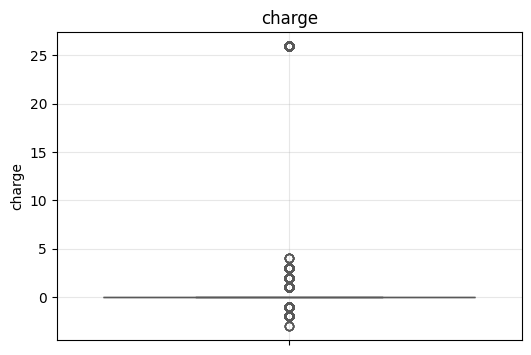

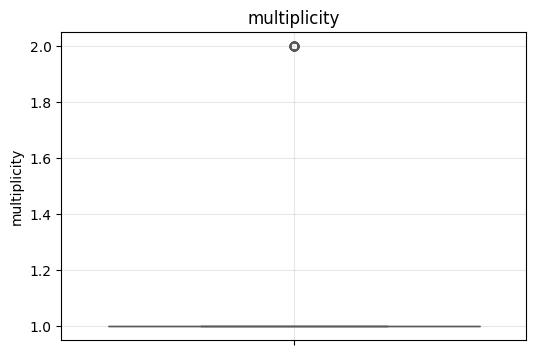

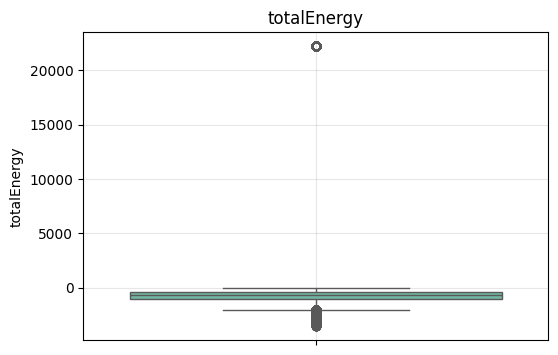

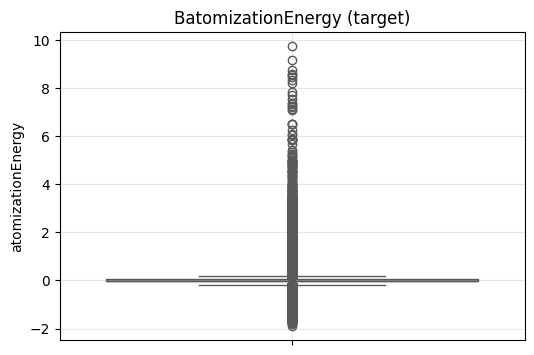

In [308]:
plt.figure(figsize=(6, 4))
sns.boxplot(y=train_data['charge'])
plt.title('charge')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(y=train_data['multiplicity'])
plt.title('multiplicity')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(y=train_data['totalEnergy'])
plt.title('totalEnergy')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(y=train_target)
plt.title('BatomizationEnergy (target)')
plt.grid(True, alpha=0.3)
plt.show()

### На основе анализа boxplot видно, что в данных есть выбросы в признаках charge и totalEnergy.Признак multiplicity почти не имеет разброса (все значения = 1), кроме одного случая = 2, что можно оставить как частный случай

### немного почистим данные (так как очевидны некоторые выбросы)
1) Удаляю очень большие totalEnergy
2) Удаляю слишком большие заряды (charge > 10)

In [309]:
train_data = train_data[train_data['totalEnergy'] < 1000]
train_target = train_target[train_data.index]  

train_data = train_data[train_data['charge'] <= 10]
train_target = train_target[train_data.index]

## 1.2.	Обучите базовую модель и выполните проверку качества работы по метрикам r2 и MAE. Данная модель нужна для оценки влияния feature-инжиниринга на качество предсказаний. Будем обучать только на тех данных, которые не содержат в себе списков

In [310]:
base_features = ['charge', 'multiplicity', 'totalEnergy']

X = train_data[base_features].copy()

X_train, X_val, y_train, y_val = train_test_split(X, train_target, test_size=0.2)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

r2 = r2_score(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)

print(f"R²:  {r2:.4f}")
print(f"MAE: {mae:.4f}")

R²:  0.2899
MAE: 0.1085


## ``` 1.3.	Проведите feature-инжиниринг: ```

### 1.3.1.	Для каждой фичи, содержащей массивы, создайте новую фичу, отражающую длину данного массива;

In [311]:
cols = ['positions', 'gradient', 'dipoleMoment', 'atomicNumbers', 'elements']

for col in cols:
    train_data[col + '_len'] = train_data[col].apply(len)

for col in cols:
    test_data[col + '_len'] = test_data[col].apply(len)

### 1.3.2.	Для фичи positions создайте новый столбец, содержащий максимальное декартово расстояние для атома от центра координат;

### 1.3.3.	Для фичи positions создайте новый столбец, содержащий минимальное декартово расстояние для атома от центра координат;

In [312]:
train_data['positions'].iloc[0]

array([[ 2.7177422 ,  0.18937249,  1.18467343],
       [ 1.03808224, -0.4019455 ,  1.06548548],
       [-0.12237377, -0.01885451, -0.06251053],
       [-1.32494175,  0.2404345 , -1.17703557],
       [-0.44313177,  1.46640849,  0.76972646],
       [ 0.85402721,  0.88601547, -0.90184551],
       [-1.25653672, -0.94711351,  0.75952345],
       [ 0.32836422, -1.28299451, -0.85143453]])

In [313]:
def get_min_max(positions):
    distances = []
    for x, y, z in positions:
        d = math.sqrt(x**2 + y**2 + z**2)
        distances.append(d)
    return min(distances), max(distances)

train_data['min_dist_center'] = train_data['positions'].apply(lambda x: get_min_max(x)[0])
train_data['max_dist_center'] = train_data['positions'].apply(lambda x: get_min_max(x)[1])

test_data['min_dist_center'] = test_data['positions'].apply(lambda x: get_min_max(x)[0])
test_data['max_dist_center'] = test_data['positions'].apply(lambda x: get_min_max(x)[1])

### 1.3.4.	Для фичи positions создайте новый столбец, содержащий среднее декартово расстояние между двумя атомами молекулы;

In [314]:
def avg_dist(positions):
    avg_dists = []
    for pos in positions:
        if len(pos) <= 1:
            avg_dists.append(0)
        else:
            distances = pdist(np.array(pos))
            avg_dists.append(distances.mean())
    return avg_dists

train_data['avg_dist_atoms'] = avg_dist(train_data['positions'])
test_data['avg_dist_atoms'] = avg_dist(test_data['positions'])

### 1.3.5.	Для фичи atomicNumbers или elements подсчитайте кол-во входящих в молекулу атомов водорода, лития, углерода, кислорода, фтора, фосфора и добавьте в качестве отдельных столбцов;

In [315]:
elements = ['H', 'Li', 'C', 'O', 'F', 'P']

for el in elements:
    train_data[f'count_{el}'] = train_data['elements'].apply(lambda x : list(x).count(el))

for elem in elements:
    test_data[f'count_{el}'] = test_data['elements'].apply(lambda x : list(x).count(el))

In [316]:
train_data

,positions,atomicNumbers,elements,charge,multiplicity,totalEnergy,gradient,dipoleMoment,positions_len,gradient_len,...,elements_len,min_dist_center,max_dist_center,avg_dist_atoms,count_H,count_Li,count_C,count_O,count_F,count_P
id,,,,,,,,,,,,,,,,,,,,,
289436,"[[2.7177422046661377, 0.1893724948167801, 1.18...","[3, 9, 15, 9, 9, 9, 9, 9]","[Li, F, P, F, F, F, F, F]",0.0,1.0,-948.513236,"[[0.023912517353892326, -0.0009200238273479044...","[[2.482706308364868], [0.08775771409273148], [...",8,8,...,8,0.138703,2.970763,2.541398,0,1,0,0,6,1
172291,"[[-2.809769630432129, 0.4285517930984497, -0.9...","[6, 6, 8, 6, 8, 6, 8, 1, 1, 1, 1, 1, 1, 6, 6, ...","[C, C, O, C, O, C, O, H, H, H, H, H, H, C, C, ...",0.0,1.0,-763.972140,"[[-0.034905705600976944, 0.02429979108273983, ...","[[0.865788459777832], [-0.3534996509552002], [...",26,26,...,26,1.101861,5.615076,4.785463,12,0,8,6,0,0
16145,"[[-0.6849300861358643, 1.1698198318481445, 0.7...","[6, 8, 6, 8, 6, 1, 1, 8, 1, 1]","[C, O, C, O, C, H, H, O, H, H]",0.0,1.0,-342.612273,"[[-0.02598184533417225, 0.0659920945763588, -0...","[[0.14613808691501617], [0.9436573386192322], ...",10,10,...,10,0.783036,2.513283,2.413279,4,0,3,3,0,0
12345,"[[4.158249855041504, 0.05714491382241249, -1.7...","[6, 8, 8, 8, 6, 6, 1, 1, 1, 1, 1, 1, 6, 8, 8, ...","[C, O, O, O, C, C, H, H, H, H, H, H, C, O, O, ...",0.0,1.0,-687.610542,"[[-0.1062416285276413, -0.05160133168101311, 0...","[[0.11332525312900543], [-0.21154789626598358]...",24,24,...,24,2.569937,7.250494,6.442372,12,0,6,6,0,0
45824,"[[-0.47792547941207886, 0.718813419342041, -1....","[6, 8, 6, 8, 6, 1, 1, 8, 1, 1]","[C, O, C, O, C, H, H, O, H, H]",0.0,1.0,-342.626351,"[[-0.01953810453414917, -0.0053415680304169655...","[[-0.7459930777549744], [0.6138357520103455], ...",10,10,...,10,0.789052,2.459697,2.379582,4,0,3,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,"[[1.3755831718444824, 1.8097169399261475, -0.9...","[6, 8, 6, 8, 6, 1, 1, 8, 1, 1, 6, 8, 6, 8, 6, ...","[C, O, C, O, C, H, H, O, H, H, C, O, C, O, C, ...",0.0,1.0,-685.243087,"[[0.04350731149315834, 0.020168600603938103, 0...","[[-1.6112534999847412], [-0.4080508351325989],...",20,20,...,20,1.752681,5.023715,4.225576,8,0,6,6,0,0
259178,"[[-1.8912068605422974, -0.7673141956329346, -2...","[9, 15, 9, 9, 9, 9, 9, 6, 6, 8, 6, 8, 8, 9, 1,...","[F, P, F, F, F, F, F, C, C, O, C, O, O, F, H, ...",0.0,1.0,-1832.333954,"[[0.06576894223690033, 0.008227618411183357, 0...","[[2.740854024887085], [1.8966714143753052], [1...",28,28,...,28,0.871396,6.238849,5.202974,6,1,6,6,8,1
131932,"[[2.2375781536102295, 1.9658761024475098, -3.9...","[6, 8, 6, 8, 6, 1, 1, 8, 1, 1, 6, 8, 6, 8, 6, ...","[C, O, C, O, C, H, H, O, H, H, C, O, C, O, C, ...",0.0,1.0,-1027.839511,"[[-0.013407240621745586, 0.057573262602090836,...","[[1.6949660778045654], [-1.9628844261169434], ...",30,30,...,30,1.012619,7.210260,5.931270,12,0,9,9,0,0


### 1.3.6.	Для столбца elements подсчитайте количество связей между кислородом и углеродом (CΞO | ОΞС). Количество таких связей добавьте в качестве нового столбца;

### 1.3.7.	Для столбца elements подсчитайте количество связей между водородом и углеродом (CΞH | HΞС). Количество таких связей добавьте в качестве нового столбца;


### 1.3.8.	Для столбца elements подсчитайте количество связей между углеродом и углеродом (CΞC). Количество таких связей добавьте в качестве нового столбца;

In [317]:
def count_connections(elements):
    elements = list(elements) 
    n = len(elements)
    c_o = 0
    c_h = 0
    c_c = 0
    for i in range(n):
        for j in range(i + 1, n):
            el1, el2= elements[i], elements[j]
            if (el1 == 'C' and el2 == 'O') or (el1 == 'O' and el2 == 'C'):
                c_o += 1
            elif (el1 == 'C' and el2 == 'H') or (el1 == 'H' and el2 == 'C'):
                c_h += 1
            elif el1 == 'C' and el2 == 'C':
                c_c += 1
    return c_o, c_h, c_c

train_data[['CΞO', 'CΞH', 'CΞC']] = train_data['elements'].apply(lambda x: pd.Series(count_connections(x)))

test_data[['CΞO', 'CΞH', 'CΞC']] = test_data['elements'].apply(lambda x: pd.Series(count_connections(x)))


### 1.3.9.	Для фичи gradient создайте новый столбец, содержащий максимальный модуль градиента для всех атомов в молекуле;

In [318]:
train_data.head()

,positions,atomicNumbers,elements,charge,multiplicity,totalEnergy,gradient,dipoleMoment,positions_len,gradient_len,...,avg_dist_atoms,count_H,count_Li,count_C,count_O,count_F,count_P,CΞO,CΞH,CΞC
id,,,,,,,,,,,,,,,,,,,,,
289436,"[[2.7177422046661377, 0.1893724948167801, 1.18...","[3, 9, 15, 9, 9, 9, 9, 9]","[Li, F, P, F, F, F, F, F]",0.0,1.0,-948.513236,"[[0.023912517353892326, -0.0009200238273479044...","[[2.482706308364868], [0.08775771409273148], [...",8,8,...,2.541398,0,1,0,0,6,1,0,0,0
172291,"[[-2.809769630432129, 0.4285517930984497, -0.9...","[6, 6, 8, 6, 8, 6, 8, 1, 1, 1, 1, 1, 1, 6, 6, ...","[C, C, O, C, O, C, O, H, H, H, H, H, H, C, C, ...",0.0,1.0,-763.972140,"[[-0.034905705600976944, 0.02429979108273983, ...","[[0.865788459777832], [-0.3534996509552002], [...",26,26,...,4.785463,12,0,8,6,0,0,48,96,28
16145,"[[-0.6849300861358643, 1.1698198318481445, 0.7...","[6, 8, 6, 8, 6, 1, 1, 8, 1, 1]","[C, O, C, O, C, H, H, O, H, H]",0.0,1.0,-342.612273,"[[-0.02598184533417225, 0.0659920945763588, -0...","[[0.14613808691501617], [0.9436573386192322], ...",10,10,...,2.413279,4,0,3,3,0,0,9,12,3
12345,"[[4.158249855041504, 0.05714491382241249, -1.7...","[6, 8, 8, 8, 6, 6, 1, 1, 1, 1, 1, 1, 6, 8, 8, ...","[C, O, O, O, C, C, H, H, H, H, H, H, C, O, O, ...",0.0,1.0,-687.610542,"[[-0.1062416285276413, -0.05160133168101311, 0...","[[0.11332525312900543], [-0.21154789626598358]...",24,24,...,6.442372,12,0,6,6,0,0,36,72,15
45824,"[[-0.47792547941207886, 0.718813419342041, -1....","[6, 8, 6, 8, 6, 1, 1, 8, 1, 1]","[C, O, C, O, C, H, H, O, H, H]",0.0,1.0,-342.626351,"[[-0.01953810453414917, -0.0053415680304169655...","[[-0.7459930777549744], [0.6138357520103455], ...",10,10,...,2.379582,4,0,3,3,0,0,9,12,3


In [319]:
train_data['gradient'].iloc[0]

array([[ 0.02391252, -0.00092002,  0.01072452],
       [-0.02625988, -0.01572946, -0.03202467],
       [ 0.21175537, -0.04765571,  0.0227595 ],
       [-0.0387703 , -0.01637066, -0.04190235],
       [ 0.0009817 ,  0.10403049,  0.00815223],
       [-0.07116375, -0.01307281,  0.01509747],
       [-0.07013033, -0.0611343 , -0.00414912],
       [-0.03010441,  0.05095642,  0.02133997]])

In [320]:
max_grad = []
for grad_list in train_data['gradient']:
    modules = []
    for x, y, z in grad_list:
        mod = math.sqrt(x**2 + y**2 + z**2)
        modules.append(mod)
    if modules:
        max_grad.append(max(modules))
    else: 
        max_grad.append(0)

train_data['max_gradient'] = max_grad

max_grad = []
for grad_list in test_data['gradient']:
    modules = []
    for x, y, z in grad_list:
        mod = math.sqrt(x**2 + y**2 + z**2)
        modules.append(mod)
    if modules:
        max_grad.append(max(modules))
    else: 
        max_grad.append(0)

test_data['max_gradient'] = max_grad

In [321]:
train_data.head(10)

,positions,atomicNumbers,elements,charge,multiplicity,totalEnergy,gradient,dipoleMoment,positions_len,gradient_len,...,count_H,count_Li,count_C,count_O,count_F,count_P,CΞO,CΞH,CΞC,max_gradient
id,,,,,,,,,,,,,,,,,,,,,
289436,"[[2.7177422046661377, 0.1893724948167801, 1.18...","[3, 9, 15, 9, 9, 9, 9, 9]","[Li, F, P, F, F, F, F, F]",0.0,1.0,-948.513236,"[[0.023912517353892326, -0.0009200238273479044...","[[2.482706308364868], [0.08775771409273148], [...",8,8,...,0,1,0,0,6,1,0,0,0,0.218242
172291,"[[-2.809769630432129, 0.4285517930984497, -0.9...","[6, 6, 8, 6, 8, 6, 8, 1, 1, 1, 1, 1, 1, 6, 6, ...","[C, C, O, C, O, C, O, H, H, H, H, H, H, C, C, ...",0.0,1.0,-763.972140,"[[-0.034905705600976944, 0.02429979108273983, ...","[[0.865788459777832], [-0.3534996509552002], [...",26,26,...,12,0,8,6,0,0,48,96,28,0.106125
16145,"[[-0.6849300861358643, 1.1698198318481445, 0.7...","[6, 8, 6, 8, 6, 1, 1, 8, 1, 1]","[C, O, C, O, C, H, H, O, H, H]",0.0,1.0,-342.612273,"[[-0.02598184533417225, 0.0659920945763588, -0...","[[0.14613808691501617], [0.9436573386192322], ...",10,10,...,4,0,3,3,0,0,9,12,3,0.128957
12345,"[[4.158249855041504, 0.05714491382241249, -1.7...","[6, 8, 8, 8, 6, 6, 1, 1, 1, 1, 1, 1, 6, 8, 8, ...","[C, O, O, O, C, C, H, H, H, H, H, H, C, O, O, ...",0.0,1.0,-687.610542,"[[-0.1062416285276413, -0.05160133168101311, 0...","[[0.11332525312900543], [-0.21154789626598358]...",24,24,...,12,0,6,6,0,0,36,72,15,0.215810
45824,"[[-0.47792547941207886, 0.718813419342041, -1....","[6, 8, 6, 8, 6, 1, 1, 8, 1, 1]","[C, O, C, O, C, H, H, O, H, H]",0.0,1.0,-342.626351,"[[-0.01953810453414917, -0.0053415680304169655...","[[-0.7459930777549744], [0.6138357520103455], ...",10,10,...,4,0,3,3,0,0,9,12,3,0.085594
91156,"[[0.027523551136255264, -0.749214231967926, -3...","[6, 8, 6, 8, 6, 1, 1, 8, 1, 1, 6, 8, 6, 8, 6, ...","[C, O, C, O, C, H, H, O, H, H, C, O, C, O, C, ...",0.0,1.0,-685.243333,"[[-0.024280987679958344, -0.08726127445697784,...","[[0.5510663986206055], [-0.5386888980865479], ...",20,20,...,8,0,6,6,0,0,36,48,15,0.156164
159539,"[[-0.6052943468093872, -1.2795850038528442, -1...","[6, 8, 8, 8, 6, 6, 6, 1, 1, 6, 1, 1, 1, 1, 1, ...","[C, O, O, O, C, C, C, H, H, C, H, H, H, H, H, ...",0.0,1.0,-864.426889,"[[0.026367900893092155, -0.09757702052593231, ...","[[-0.9482130408287048], [0.39238420128822327],...",28,28,...,13,0,8,6,1,0,48,104,28,0.269158
56089,"[[-0.9295830726623535, -1.1432020664215088, 0....","[6, 8, 6, 8, 6, 8, 9, 1, 1, 1]","[C, O, C, O, C, O, F, H, H, H]",0.0,1.0,-441.897739,"[[0.09752633422613144, -0.016479119658470154, ...","[[-0.1964234709739685], [-0.9894622564315796],...",10,10,...,3,0,3,3,1,0,9,9,3,0.232693
145464,"[[-4.569830894470215, 1.5883574485778809, 1.13...","[6, 8, 6, 8, 6, 1, 1, 8, 1, 1, 6, 8, 6, 8, 6, ...","[C, O, C, O, C, H, H, O, H, H, C, O, C, O, C, ...",0.0,1.0,-1027.860330,"[[-0.022074485197663307, 0.062386248260736465,...","[[-0.6232782602310181], [1.9315261840820312], ...",30,30,...,12,0,9,9,0,0,81,108,36,0.151730


### 1.3.10.	Для фичи dipoleMoment создайте новый столбец, содержащий модуль вектора дипольного момента для молекулы.

In [322]:
dipole = []
for d in train_data['dipoleMoment']:
    x, y, z = d
    mod = math.sqrt(x**2 + y**2 + z**2)
    dipole.append(mod)

train_data['dipole_magnitude'] = dipole

dipole = []
for d in test_data['dipoleMoment']:
    x, y, z = d
    mod = math.sqrt(x**2 + y**2 + z**2)
    dipole.append(mod)
test_data['dipole_magnitude'] = dipole

## 1.4.	Проведите анализ фичей, уберите ненужные.

### сначала удалим столбцы которые хранят в себе массивы, списки

In [323]:
train_data.head(1)

,positions,atomicNumbers,elements,charge,multiplicity,totalEnergy,gradient,dipoleMoment,positions_len,gradient_len,...,count_Li,count_C,count_O,count_F,count_P,CΞO,CΞH,CΞC,max_gradient,dipole_magnitude
id,,,,,,,,,,,,,,,,,,,,,
289436,"[[2.7177422046661377, 0.1893724948167801, 1.18...","[3, 9, 15, 9, 9, 9, 9, 9]","[Li, F, P, F, F, F, F, F]",0.0,1.0,-948.513236,"[[0.023912517353892326, -0.0009200238273479044...","[[2.482706308364868], [0.08775771409273148], [...",8,8,...,1,0,0,6,1,0,0,0,0.218242,2.661512


In [324]:

cols_to_drop = ['positions', 'gradient', 'dipoleMoment', 'atomicNumbers', 'elements']

if cols_to_drop:
    train_data = train_data.drop(columns=cols_to_drop)
    test_data = test_data.drop(columns=cols_to_drop)

In [325]:
train_data["dipoleMoment_len"]

id
289436    3
172291    3
16145     3
12345     3
45824     3
         ..
119879    3
259178    3
131932    3
146867    3
121958    3
Name: dipoleMoment_len, Length: 266380, dtype: int64

In [326]:
train_data["multiplicity"]

id
289436    1.0
172291    1.0
16145     1.0
12345     1.0
45824     1.0
         ... 
119879    1.0
259178    1.0
131932    1.0
146867    1.0
121958    1.0
Name: multiplicity, Length: 266380, dtype: float64

In [327]:
train_data["dipoleMoment_len"].unique()

array([3])

In [328]:
print(train_data["multiplicity"].unique()) 

[1. 2.]


### заметим что столбец train_data["dipoleMoment_len"] заполнен одинаковыми значениями 3, следовательно его можно удалить. столбец train_data["multiplicity"] заполнен только 1 ( зачение 2 скорее всего выброс, как мы и преполагали ранее), также можно удалить

In [329]:
train_data = train_data.drop(columns=["dipoleMoment_len"])

In [330]:
train_data = train_data.drop(columns=["multiplicity"])

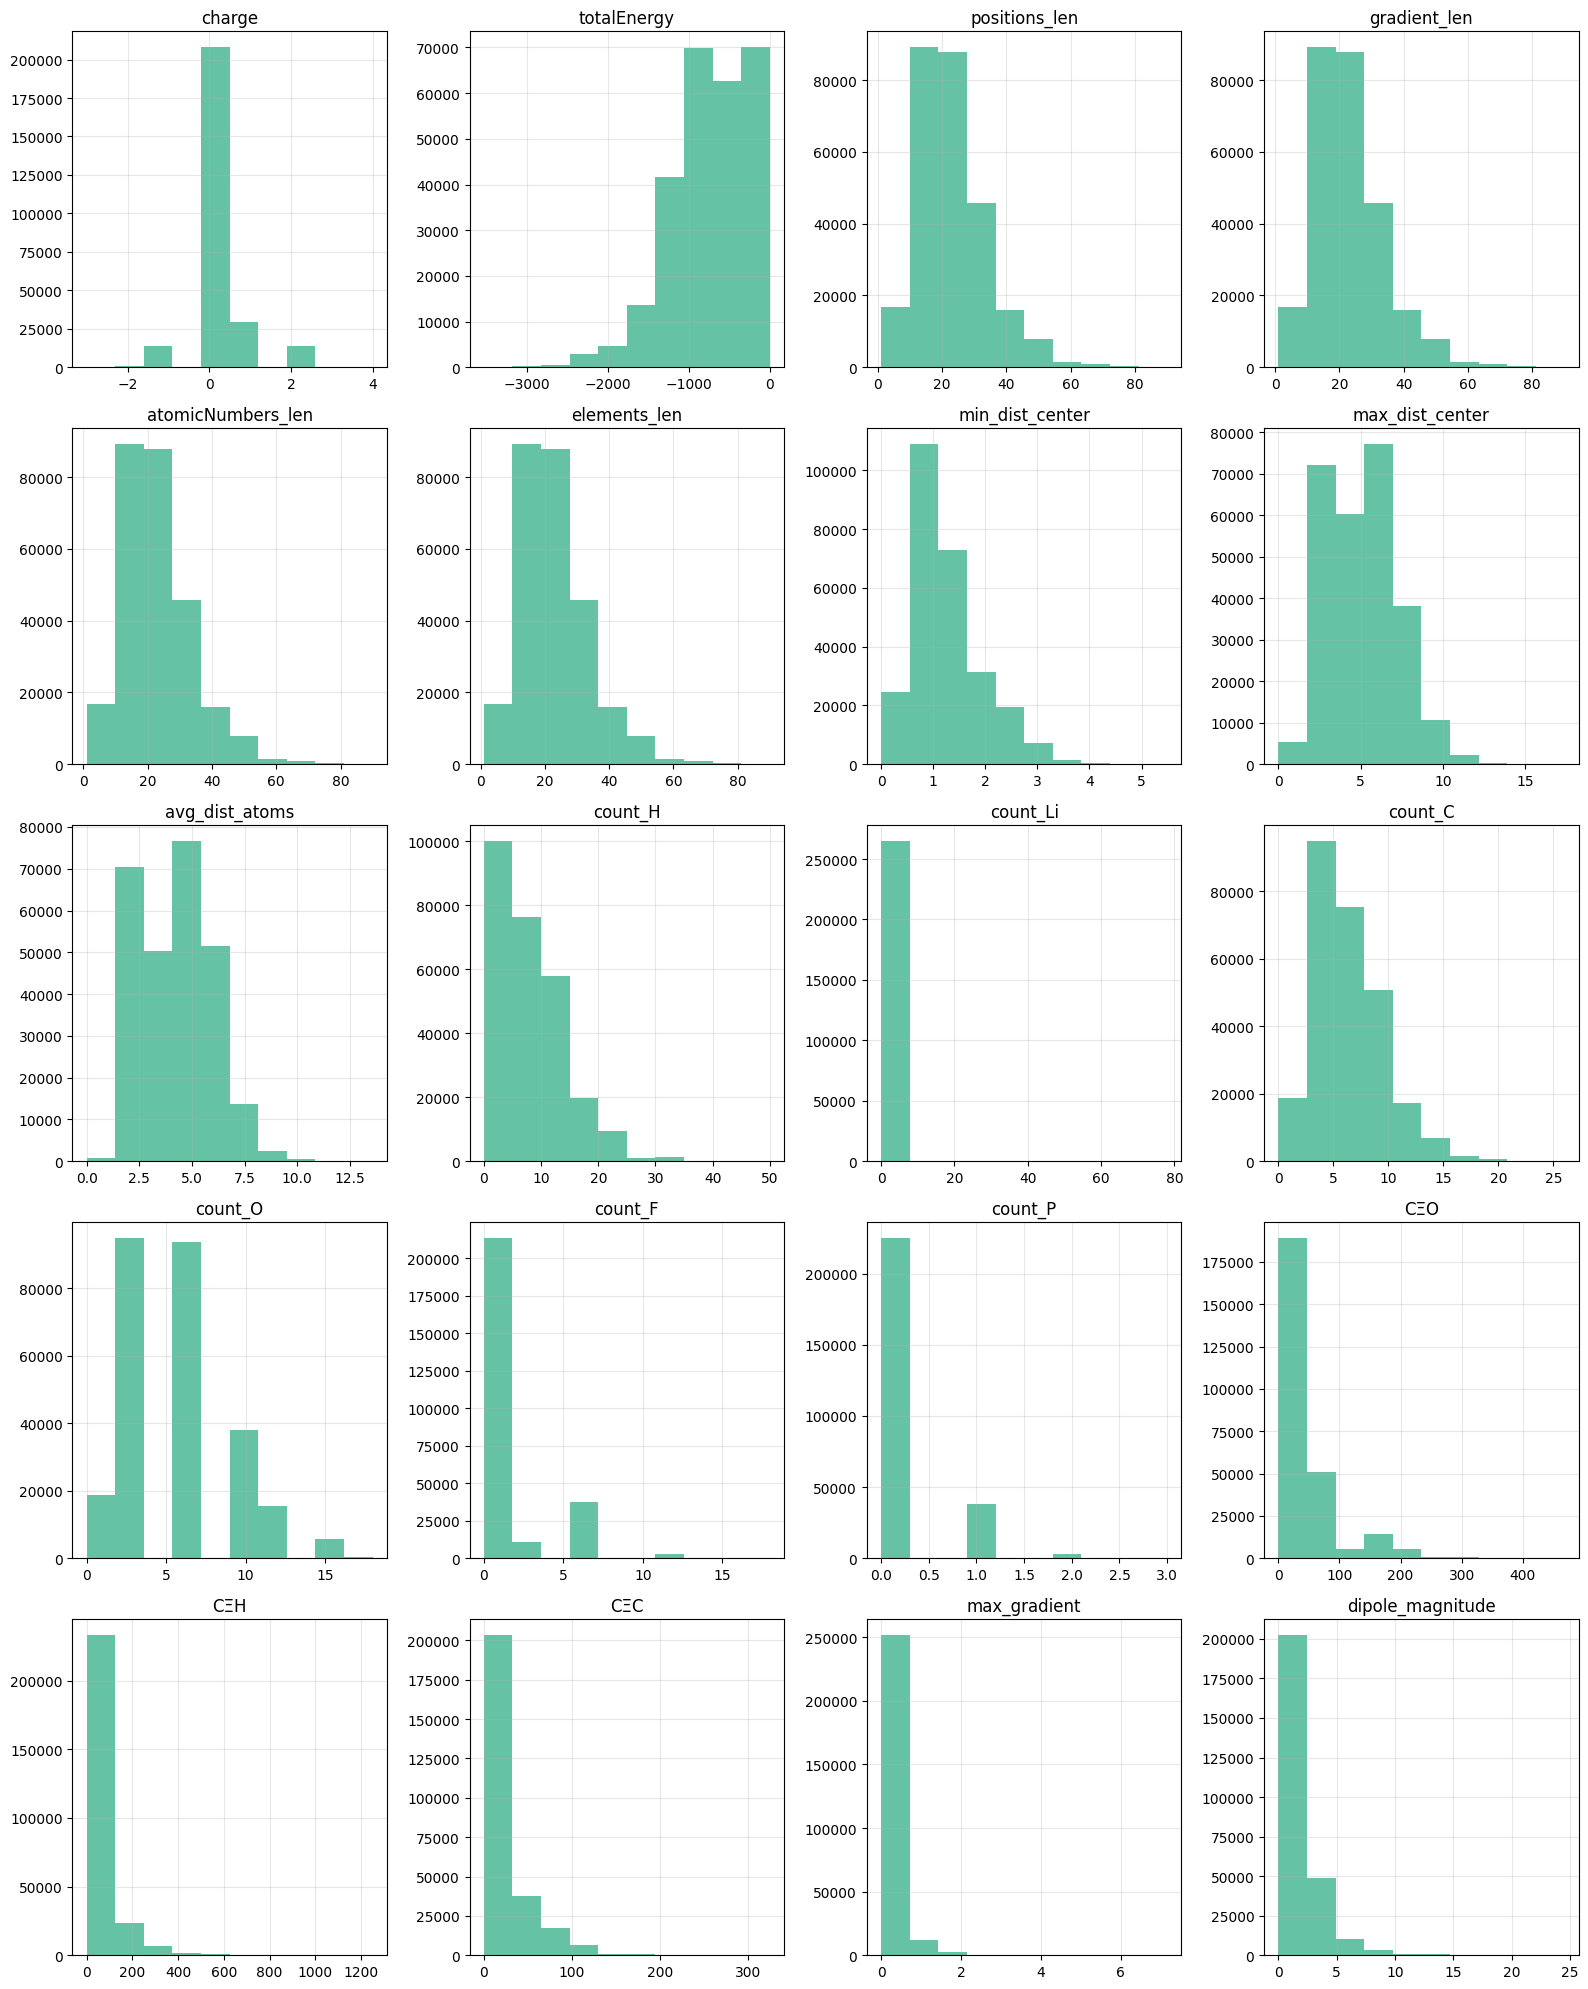

In [331]:
cols = train_data.columns.tolist()
n = len(cols)

cols_per_row = 4
rows = math.ceil(n / cols_per_row)

plt.figure(figsize=(16, 4 * rows))

for i, col in enumerate(cols):
    plt.subplot(rows, cols_per_row, i + 1)
    plt.hist(train_data[col])
    plt.title(col)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### positions_len, atomicNumbers_len, elements_len имеют одинаковые распределения
Это значит: они равны друг другу и можно оставить только один, например positions_len. Перед этим проверим карреляцию

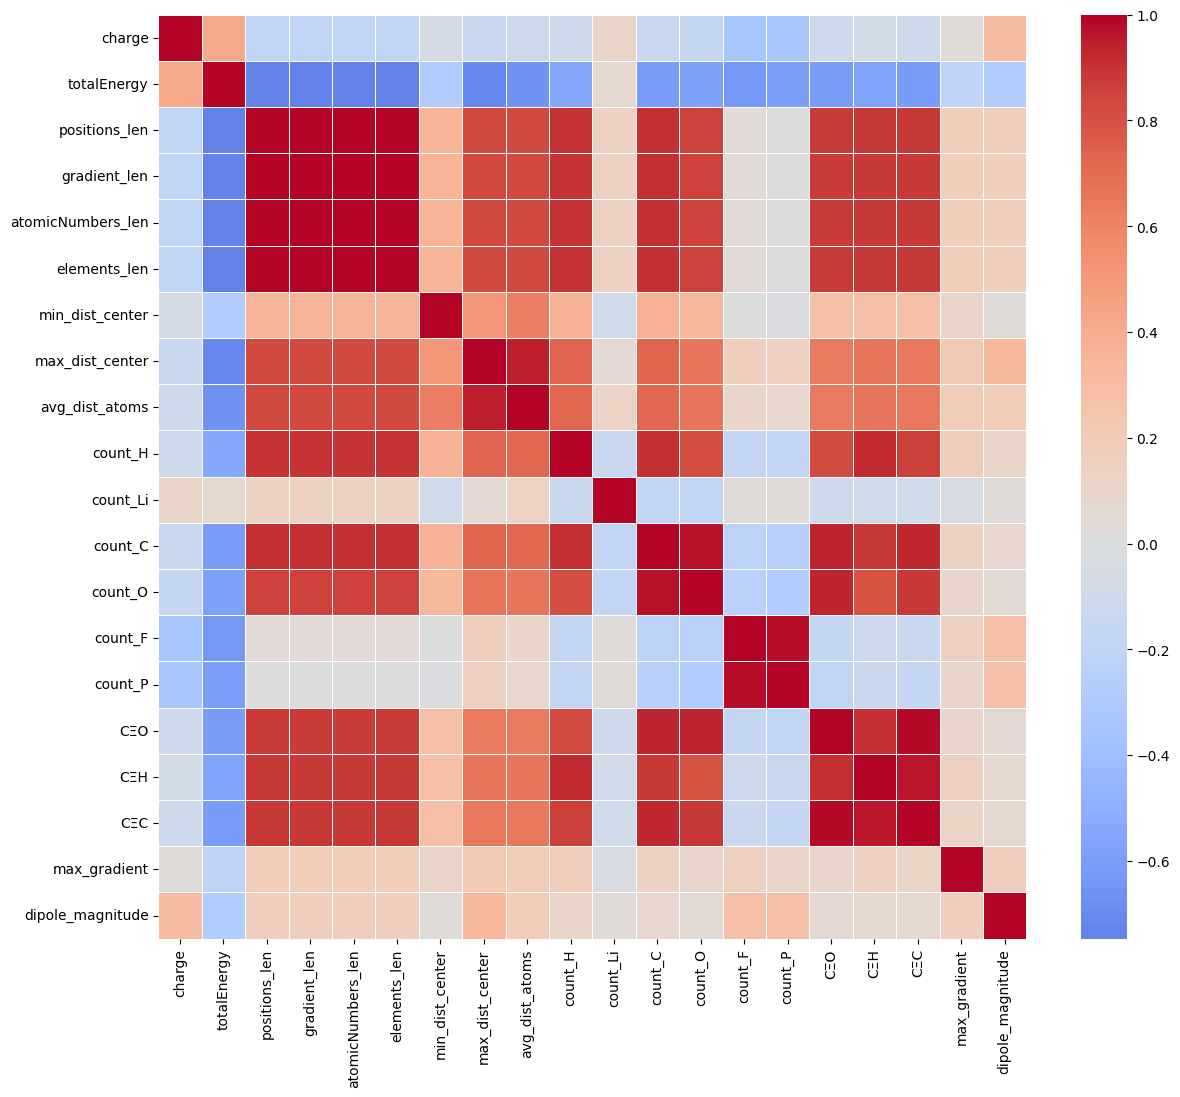

In [332]:
corr = train_data.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0, linewidths=0.5)
plt.show()

### заметим сильную карреляцию между ними, поэтому спокойно удаляем

In [333]:
train_data = train_data.drop(columns=['atomicNumbers_len', 'elements_len'])
test_data = test_data.drop(columns=['atomicNumbers_len', 'elements_len'])

## 1.5.	Создайте функцию для предварительной обработки данных, принимающую на вход датафрейм или путь к файлу, а на выходе возвращающую датафрейм, готовый к обучению моделей. Примените функцию к наборам данных train_data, test_data.

In [334]:
def preprocess_data(df):
    df = df.copy()

    df = df.dropna(subset=['positions', 'elements', 'gradient', 'dipoleMoment']).reset_index(drop=True)
    
    # 1.3.1
    df['positions_len'] = df['positions'].apply(len)
    df['gradient_len'] = df['gradient'].apply(len)
    df['dipoleMoment_len'] = df['dipoleMoment'].apply(len)
    
    # 1.3.2–1.3.3
    def get_min_max(positions):
        distances = [math.sqrt(x**2 + y**2 + z**2) for x, y, z in positions]
        return min(distances), max(distances)
    
    df[['min_dist_center', 'max_dist_center']] = df['positions'].apply(lambda x: pd.Series(get_min_max(x)))
    
    # 1.3.4
    def avg_dist(positions):
        if len(positions) <= 1:
            return 0
        return pdist(np.array(positions)).mean()
    
    df['avg_dist_atoms'] = df['positions'].apply(avg_dist)
    
    # 1.3.5
    elements_list = ['H', 'Li', 'C', 'O', 'F', 'P']
    for el in elements_list:
        df[f'count_{el}'] = df['elements'].apply(lambda x: list(x).count(el))
    
    # 1.3.6–1.3.8
    def count_connections(elements):
        elements = list(elements)
        c_o = c_h = c_c = 0
        n = len(elements)
        for i in range(n):
            for j in range(i + 1, n):
                a, b = elements[i], elements[j]
                if (a == 'C' and b == 'O') or (a == 'O' and b == 'C'):
                    c_o += 1
                elif (a == 'C' and b == 'H') or (a == 'H' and b == 'C'):
                    c_h += 1
                elif a == 'C' and b == 'C':
                    c_c += 1
        return pd.Series([c_o, c_h, c_c])
    
    df[['CΞO', 'CΞH', 'CΞC']] = df['elements'].apply(count_connections)
    
    # 1.3.9
    def max_gradient(grad_list):
        mods = [math.sqrt(x**2 + y**2 + z**2) for x, y, z in grad_list]
        return max(mods) if mods else 0
    df['max_gradient'] = df['gradient'].apply(max_gradient)
    
    # 1.3.10
    def dipole_mag(dvec):
        x, y, z = dvec
        return math.sqrt(x**2 + y**2 + z**2)
    df['dipole_magnitude'] = df['dipoleMoment'].apply(dipole_mag)

    cols_to_drop = ['positions', 'gradient', 'dipoleMoment', 'atomicNumbers', 'elements']
    df = df.drop(columns=cols_to_drop)

    df = df.drop(columns=['dipoleMoment_len', 'multiplicity'], errors='ignore')
    df = df.drop(columns=['atomicNumbers_len', 'elements_len'], errors='ignore')
    
    return df

In [335]:
with open('Train_data.pickle', 'rb') as f:
    train_data_raw = pickle.load(f)
with open('Train_target.pickle', 'rb') as f:
    train_target = pickle.load(f)
with open('Test_data.pickle', 'rb') as f:
    test_data_raw = pickle.load(f)

train_data_raw = preprocess_data(train_data_raw)
test_data_raw = preprocess_data(test_data_raw)

## 1.6.	Обучите как минимум 3 алгоритма машинного обучения для предсказания таргета (atomizationEnergy).

## 1.7.	Проведите оценку точности обученных алгоритмов по метрикам r2 и MAE, оцените время обучения для каждого из алгоритмов. Выберите лучший алгоритм.

In [337]:
X_train, X_val, y_train, y_val = train_test_split(train_data, train_target, test_size=0.2, random_state=42)


start = time.time()
model1 = LinearRegression()
model1.fit(X_train, y_train)
model1_pred = model1.predict(X_val)
model1_time = time.time() - start
model1_r2 = r2_score(y_val, model1_pred)
model1_mae = mean_absolute_error(y_val, model1_pred)
print(f"R2: {model1_r2:.4f}, MAE: {model1_mae:.4f}, время: {model1_time:.2f} сек")


start = time.time()
model2 = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model2.fit(X_train, y_train)
model2_pred = model2.predict(X_val)
model2_time = time.time() - start
model2_r2 = r2_score(y_val, model2_pred)
model2_mae = mean_absolute_error(y_val, model2_pred)
print(f"R2: {model2_r2:.4f}, MAE: {model2_mae:.4f}, время: {model2_time:.2f} сек")


start = time.time()
model3 = GradientBoostingRegressor(n_estimators=100, random_state=42)
model3.fit(X_train, y_train)
model3_pred = model3.predict(X_val)
model3_time = time.time() - start
model3_r2 = r2_score(y_val, model3_pred)
model3_mae = mean_absolute_error(y_val, model3_pred)
print(f"R2: {model3_r2:.4f}, MAE: {model3_mae:.4f}, время: {model3_time:.2f} сек")


ValueError: Found input variables with inconsistent numbers of samples: [266380, 271786]

## 1.8.	Выполните предсказание на тестовой выборке. Результат сохраните в формате, полностью идентичном формату файла M3_sample_submission.csv. 